In [1]:
import warnings
from os.path import join, isdir, isfile
from os import mkdir
from typing import Union
import numpy as np
import pandas as pd
from tqdm import tqdm
import dill as pickle
from datetime import datetime
from scipy.stats import wasserstein_distance

from sklearn.metrics import accuracy_score, balanced_accuracy_score, auc
from sklearn.linear_model import LinearRegression, SGDClassifier

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from IPython.display import display, HTML

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
from torch.nn.functional import softmax

from utils import worst_subgroup_accuracy, subgroup_accuracy

from config import get_config
from datasets import BiasSubset
from datasets.utils import BalancedSampler
from models.utils import extract_features
from shortcut_removal.dfr import DeepFeatureReweighting
from shortcut_removal.dfr import CustomLogisticRegression

In [ ]:
# NOTE: Cell tagged as 'parameters' to allow for execution with
# papermill/nbconvert.

# Reproducibility.
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# General settings.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "./data/"

# Matplotlib settings.
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
mpl.rc('text', usetex=True)

# Visualization settings.
# The colors are taken from tab20.
colors = {
    "ERM": ("#1f77b4", "#aec7e8", "--"),
    "DFR": ("#ff7f0e", "#ffbb78", ":"),
    "EvA": ("#E377C2", "#F7B6D2", "-."),
    "AMSEL (Ours)": ("#2CA02C", "#98DF8A", "-"),
}

# Experiment-specific settings.
balancing_factor_step = 0.05
balancing_factor_mode = "default" # 'default' vs. 'min_max'
score_mapping = "linear_regression"
score_function_name = "Consensus"
if "dataset_name" not in globals():
    dataset_names = ["celeba", "chestx-ray14"]
    dataset_name = dataset_names[0]

In [3]:
def display_df(df):
    # Introduces automatic line-breaks.
    styler = df.style.set_table_styles([dict(selector="th",props=[('max-width', '120px'), ("word-break", "break-all")])])
    display(HTML(styler.to_html()))

# Experiments for Adaptive Model Selection (AMSEL)

This notebook implements and evaluates the **Adaptive Model Selection (AMSEL)** method, as described in the paper. AMSEL addresses the problem of robust generalization under distribution shifts caused by varying degrees of spurious correlation at test time.

The method consists of three main steps:
1.  **Candidate Model Construction:** We train a family of lightweight classifier heads $\{h_\theta\}$ on a fixed feature extractor $e$. Each head is trained on a dataset $\mathcal{D}_\theta$ with a specific degree of spurious correlation, controlled by a balancing parameter $\theta$.
2.  **Estimation of Test Distribution Characteristics:** We learn a mapping $M$ from a score function $s(\cdot)$, which measures statistical properties of the input data, to the corresponding balancing parameter $\theta$.
3.  **Adaptive Inference:** At test time, we compute the score on the test data, use the mapping $M$ to estimate the test balancing parameter $\theta_{\mathrm{test}}$, and select the corresponding model $m_{\theta_{\mathrm{test}}} = h_{\theta_{\mathrm{test}}} \circ e$ for prediction.

This notebook details the implementation of this pipeline and evaluates its performance against several baselines on test sets with varying degrees of spurious correlation.

## 1. Setup and Preliminaries

This section covers the initial setup, including loading configurations, preparing datasets, and defining subgroups, which are essential for the subsequent steps.

### 1.1. Configuration and Parameters

We begin by loading the dataset-specific configuration and defining the set of balancing parameters $\theta$ that will be used to construct the candidate models and simulate different test distributions.

In [4]:
print(f"Evaluating AMSEL for the following dataset: {dataset_name}")

# Load config.
dataset_config = get_config(dataset_name, root_dir=root_dir)

# Prepare output folder.
output_dir = join(".", "outputs", dataset_name)
if not isdir(output_dir):
    print(f"Creating output directory: {output_dir}")
    mkdir(output_dir)

# Extract parameters.
regularization_parameter_c = dataset_config.regularization_parameter_c
balancing_factor_min = dataset_config.balancing_factor_min
balancing_factor_max = dataset_config.balancing_factor_max

Evaluating AMSEL for the following dataset: celeba


In [5]:
if balancing_factor_mode == "min_max":
    # Calculate the smallest multiple of step >= minimum.
    start = np.ceil(balancing_factor_min / balancing_factor_step) * balancing_factor_step

    # Calculate the largest multiple of step <= maximum.
    end = np.floor(balancing_factor_max / balancing_factor_step) * balancing_factor_step

    # Generate balancing factors.
    balancing_factors = np.arange(start, end + balancing_factor_step / 2, balancing_factor_step)
elif balancing_factor_mode == "default":
    balancing_factors = np.round(np.linspace(0, 1., 21), 2) # Round due some numbers like 0.6 becoming 0.6.....1 (precision errors)
    balancing_factor_min, balancing_factor_max = 0, 1
else:
    raise ValueError("Invalid balancing factor creation mode specified!")

assert 0 in balancing_factors and 1 in balancing_factors, "Make sure that you balancing factors contain both theta=0 and theta=1."
unbiased_model_idx = np.where(balancing_factors == 1.0)[0][0]
print("Evaluating balancing factors:", balancing_factors)

Evaluating balancing factors: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [6]:
def balancing_factor_to_index(balancing_factor: float, clip: bool = False) -> Union[float, int]:
    # While we could cast the index to int because indices have to be integers,
    # we explicitly choose to leave this to the user to ensure invertability.
    # [min, max] -> [0,1].
    balancing_factor = (balancing_factor - np.min(balancing_factors)) / (np.max(balancing_factors) - np.min(balancing_factors))

    # [0,1] -> [0, len(balancing_factors) - 1].
    balancing_factor_idx = balancing_factor * (len(balancing_factors) - 1)

    if clip:
         balancing_factor_idx = np.clip(balancing_factor_idx, a_min=0, a_max=len(balancing_factors) - 1)

    return balancing_factor_idx

def index_to_balancing_factor(balancing_factor_idx: int, clip: bool = False) -> float:
    # [0, len(balancing_factors) - 1] -> [0,1].
    balancing_factor = balancing_factor_idx / (len(balancing_factors) - 1)

    # [0,1] -> [min, max].
    balancing_factor = balancing_factor * (np.max(balancing_factors) - np.min(balancing_factors)) + np.min(balancing_factors)
    
    if clip:
        balancing_factor = np.clip(balancing_factor, a_min=np.min(balancing_factors), a_max=np.max(balancing_factors))
                                   
    return balancing_factor

### 1.2. Data Loading and Preparation

We load the validation and test datasets. Following the methodology, we split the validation set into two disjoint halves:
-   $\mathcal{D}_{\mathrm{candidate}}$ (`subset_train_dfr`): Used to train the family of candidate classifier heads $\{h_\theta\}$.
-   $\mathcal{D}_{\mathrm{mapping}}$ (`subset_train_score_mapping`): Used to learn the mapping $M$ from the consensus score to the balancing parameter $\theta$.

This separation ensures that the mapping is learned on data not seen during the training of the candidate models.

In [7]:
dataset_val, dataset_test = dataset_config.get_datasets()

In [8]:
# Note that we have to shuffle the indices because the validation dataset might
# be sorted. However, because we pass a seed, the shuffling is fully
# reproducible.
indices = list(range(len(dataset_val)))
random_generator = np.random.default_rng(seed)
random_generator.shuffle(indices)
subset_train_dfr = BiasSubset(dataset_val, indices=indices[:len(indices)//2])
subset_train_score_mapping = BiasSubset(dataset_val, indices=indices[len(indices)//2:])
subset_test = dataset_test

print("#Samples Train DFR:\t\t", len(subset_train_dfr))
print("#Samples Train Score Mapping:\t", len(subset_train_score_mapping))
print("#Samples Test:\t\t\t", len(subset_test))

#Samples Train DFR:		 9933
#Samples Train Score Mapping:	 9934
#Samples Test:			 19962


In [9]:
# Extract labels.
labels_train_dfr = np.array([subset_train_dfr.label(idx) for idx in range(len(subset_train_dfr))])
labels_train_score_mapping = np.array([subset_train_score_mapping.label(idx) for idx in range(len(subset_train_score_mapping))])
labels_test = np.array([subset_test.label(idx) for idx in range(len(subset_test))])

In [10]:
# Create dataloader.
dataloader_train_dfr = DataLoader(
    subset_train_dfr,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    pin_memory=True,
)
dataloader_train_score_mapping = DataLoader(
    subset_train_score_mapping,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    pin_memory=True,
)
dataloader_test = DataLoader(
    subset_test,
    batch_size=100,
    num_workers=8,
    shuffle=False,
    pin_memory=True,
)

### 1.3. Model and Feature Extractor

We load a standard ERM model pre-trained on the biased training set $\mathcal{D}$.
The feature extractor $e$ of this model will be fixed and used to generate feature representations for all subsequent steps.
We consider multiple ERM models (trained with different seeds) to report mean and standard deviation over our results.

In [11]:
Model = dataset_config.ModelClass
base_models = dataset_config.get_base_models()
print(f"Considering the following base models: {base_models}")

Considering the following base models: ['izmailov_resnet50_erm_seed1', 'izmailov_resnet50_erm_seed2', 'izmailov_resnet50_erm_seed3', 'izmailov_resnet50_erm_seed4', 'izmailov_resnet50_erm_seed5']


### 1.4. Subgroup Identification

As defined in the paper, we formalize bias as an imbalance between subgroups $\mathcal{G}$, where each subgroup is a combination of a class label and a bias attribute. We identify these subgroups for each data split, as the subgroup labels are required for creating the re-weighted datasets $\mathcal{D}_\theta$.


In [12]:
SubgroupIdentifier = dataset_config.SubgroupIdentifierClass
print(f"Using the following subgroup identification method: {SubgroupIdentifier}")

Using the following subgroup identification method: <class 'subgroup_identification.ground_truth.GTSubgroups'>


In [13]:
subgroup_identifier = SubgroupIdentifier()
group_ids_train_dfr, n_subgroups = subgroup_identifier.identify_subgroups(None, subset_train_dfr, device)
group_ids_train_score_mapping, _ = subgroup_identifier.identify_subgroups(None, subset_train_score_mapping, device)
group_ids_test, _ = subgroup_identifier.identify_subgroups(None, subset_test, device)
group_ids_train_dfr, group_ids_train_score_mapping, group_ids_test = [z.cpu().detach().numpy() for z in (group_ids_train_dfr, group_ids_train_score_mapping, group_ids_test)]

# Remove empty groups if desired (i.e., re-ordering such that empty groups are
# listed last and then discarding them).
if dataset_config.subgroup_postprocessor:
    n_subgroups, group_ids_train_dfr, group_ids_train_score_mapping, group_ids_test = dataset_config.subgroup_postprocessor(group_ids_train_dfr, group_ids_train_score_mapping, group_ids_test)

# Are the subgroups balanced?
print("Number of subgroups: ", n_subgroups)
print("Subgroup balancing (train DFR):", np.unique(group_ids_train_dfr, return_counts=True)[1])
print("Subgroup balancing (train score mapping):", np.unique(group_ids_train_score_mapping, return_counts=True)[1])
print("Subgroup balancing (test subset):", np.unique(group_ids_test, return_counts=True)[1])

# Test for missing subgroups.
# We expect that each subset contains all subgroups when performing the balanced
# subsampling. Alternatively, one could adapt the BalancedSampler such that it
# allows subgroups not to be present.
assert len(set(group_ids_train_dfr)) == n_subgroups, "No samples of the following subgroup(s) in subset_train_dfr: " + str(set(range(n_subgroups)).difference(set(group_ids_train_dfr))) 
assert len(set(group_ids_train_score_mapping)) == n_subgroups, "No samples of the following subgroup(s) in subset_train_score_mapping: " + str(set(range(n_subgroups)).difference(set(group_ids_train_score_mapping)))
assert len(set(group_ids_test)) == n_subgroups, "No samples of the following subgroup(s) in subset_test: " + str(set(range(n_subgroups)).difference(set(group_ids_test))) 

Extract subgroup ids: 100%|██████████| 19962/19962 [00:00<00:00, 117797.17it/s]

Number of subgroups:  4
Subgroup balancing (train DFR): [4294 4060 1479  100]
Subgroup balancing (train score mapping): [4241 4216 1395   82]
Subgroup balancing (test subset): [9767 7535 2480  180]


### 1.5. Simulating Test Distributions with Varying Bias

To evaluate the robustness of our method, we simulate a range of test distributions with varying degrees of spurious correlation. We achieve this by re-sampling the validation and test sets according to the parameterized distribution $P_\theta(Y, B) = \theta \, P_{\mathrm{bal}}(Y,B) + (1-\theta) \, P_{\mathrm{orig}}(Y,B)$, where $\theta=0$ corresponds to the original biased distribution and $\theta=1$ corresponds to a perfectly balanced one. The `BalancedSampler` generates subsets of indices that approximate these target distributions.

In [14]:
# Generate dataset subsamples with the desired balancing factors.
# Note that since we set the seed, all models are evaluated on the 
# same subsets (per balancing factor).
balancing_mode = "exact_under"
subset_indices_per_balancing_factor_train_dfr = [
    list(
        BalancedSampler(
            subset_train_dfr,
            mode=balancing_mode,
            balancing_factor=balancing_factor,
            labels=torch.tensor(group_ids_train_dfr),
            seed=seed
        )
    )
    for balancing_factor in balancing_factors
]

subset_indices_per_balancing_factor_train_score_mapping = [
    list(
        BalancedSampler(
            subset_train_score_mapping,
            mode=balancing_mode,
            balancing_factor=balancing_factor,
            labels=torch.tensor(group_ids_train_score_mapping),
            seed=seed
        )
    )
    for balancing_factor in balancing_factors
]

subset_indices_per_balancing_factor_test = [
    list(
        BalancedSampler(
            subset_test,
            mode=balancing_mode,
            balancing_factor=balancing_factor,
            labels=torch.tensor(group_ids_test),
            seed=seed
        )
    )
    for balancing_factor in balancing_factors
]

The plot below visualizes the effect of the balancing parameter $\theta$ on the subgroup composition of the resulting test subsets. As $\theta$ increases from 0 to 1, the proportions of all subgroups converge to be uniform, effectively removing the spurious correlation.

x-intercept for subgroup 1: 2.047472266076132
x-intercept for subgroup 2: 2.9624657537231305
x-intercept for subgroup 3: -0.9874687760116294
x-intercept for subgroup 4: -0.03667183962357822


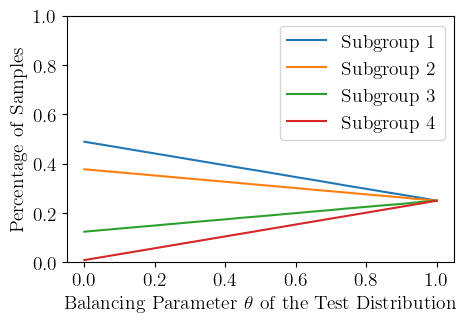

In [15]:
fig = plt.figure(figsize=(5.0,3.2))

for subgroup_id in np.unique(group_ids_test):
    counts = [np.sum(group_ids_test[indices] == subgroup_id) / len(indices) for indices in subset_indices_per_balancing_factor_test]
    plt.plot(balancing_factors, counts, label="Subgroup " + str(subgroup_id + 1))

    # Calculate intercept with the x-axis.
    lm = LinearRegression()
    lm.fit(balancing_factors.reshape(-1, 1), counts)
    slope = lm.coef_[0]
    intercept = lm.intercept_
    x_intercept = -intercept / slope
    print("x-intercept for subgroup " + str(subgroup_id + 1) + ": " + str(x_intercept))

plt.ylim(0,1)
plt.xlabel(r"Balancing Parameter $\theta$ of the Test Distribution")
plt.ylabel("Percentage of Samples")
plt.legend()

## 2. Candidate Model Construction (Step 1)

This section implements the first step of AMSEL: constructing the family of candidate models $\{m_\theta = h_\theta \circ e | \theta \in \Theta\}$. We first evaluate the baseline ERM model and then proceed to train the candidate classifier heads.

### 2.1. Baseline: ERM Model Performance

As a primary baseline, we evaluate the performance of the original ERM model on the test set. This represents the standard approach without any debiasing.

In [16]:
cache_file = join(output_dir, dataset_name + "_data_erm-pred-and-conf.pkl")
if isfile(cache_file):
    with open(cache_file, "rb") as handle:
        cache_data = pickle.load(handle)
        erm_predictions = cache_data["predictions"]
        erm_confidence_scores = cache_data["confidence_scores"]
        print("Found ERM predictions/confidence scores created at " + str(cache_data["creation_time"]) + ", loading cached data instead of recalculation.")

else:
    erm_predictions = []
    erm_confidence_scores = []
    for base_model in base_models:
        print(
            "Generating predictions for ERM model: "
            + str(base_model)
        )

        # Load corresponding ERM model.
        model = Model(root=root_dir, model=base_model, download=False).to(device)
        model = model.eval()

        # Conversion from model outputs to class label predictions.
        # We could also define this function once for all base models.
        if list(model.modules())[-1].out_features != 1:
            model_outputs_to_preds_transform = Lambda(lambda x: torch.argmax(x, dim=1))
        else:
            model_outputs_to_preds_transform = Lambda(lambda x: (x >= 0.5).long())

        # Extract predictions.
        torch.cuda.empty_cache()
        with torch.no_grad():
            # Get confidence scores.
            pred = [model(x[0].to(device)).cpu() for x in tqdm(dataloader_test)]

            # Check whether SoftMax should be applied.
            #   1. Multi-class output (sigmoid usually has a single output neuron)
            #   2. Outputs are probabilities
            #   3. Outputs are within [0,1]
            # While this does not guarantee that SoftMax should be applied, it is
            # as close as we can reasonably get without inspecting the model.
            conf = torch.cat(pred)
            if len(conf.shape) == 2 and conf.shape[1] >= 2 and not (torch.all(torch.isclose(conf.sum(dim=-1), torch.tensor(1.0, device=conf.device, dtype=conf.dtype))) and conf.min() >= 0 and conf.max() <= 1):
                warnings.warn("It seems that SoftMax has not been applied to the network output, applying it now. Please check that this is appropriate for your model!")
                conf = softmax(conf, dim=-1)
            elif len(conf.shape) == 1 and conf.min() >= 0 and conf.max() <= 1:
                warnings.warn("Converting true class probabilities to per-class probabilities.")
                conf = torch.stack([1 - conf, conf], dim=1)
            erm_confidence_scores.append(conf)

            # Convert into predictions.
            pred = torch.cat([model_outputs_to_preds_transform(p) for p in tqdm(pred)])
            erm_predictions.append(pred)
    erm_predictions = np.array(erm_predictions)
    erm_confidence_scores = np.array(erm_confidence_scores)

    # Save created predictions/conf. scores for future repeated experiments.
    with open(cache_file, "wb") as handle:
        print("Saving ERM predictions/confidence scores scores at:", cache_file)
        pickle.dump(
            {"predictions": erm_predictions, "confidence_scores": erm_confidence_scores, "creation_time": datetime.now()},
            handle,
            protocol=pickle.HIGHEST_PROTOCOL
        )

Found ERM predictions/confidence scores created at 2025-07-11 19:48:29.577697, loading cached data instead of recalculation.


In [17]:
# Calculate Accuracy and Worst-Subgroup Accuracy.
erm_accuracies = np.array([accuracy_score(labels_test, p) for p in erm_predictions])
erm_wsg_accuracies = np.array(
    [worst_subgroup_accuracy(labels_test, p, group_ids_test) for p in erm_predictions]
)
erm_per_subgroup_accuracies = np.array(
    [subgroup_accuracy(labels_test, p, group_ids_test, aggregation="none") for p in erm_predictions]
)

In [18]:
print("Accuracies: " + str(erm_accuracies))
print("Worst-Group Accuracies: " + str(erm_wsg_accuracies))
print("Per-Subgroup Accuracies: " + str([f"{np.mean(a):.2%}±{np.std(a):.2%}" for a in erm_per_subgroup_accuracies.T]))

Accuracies: [0.95521491 0.95601643 0.95436329 0.95511472 0.95892195]
Worst-Group Accuracies: [0.47777778 0.46111111 0.42222222 0.60555556 0.50555556]
Per-Subgroup Accuracies: ['96.07%±0.39%', '99.19%±0.25%', '86.15%±2.50%', '49.44%±6.18%']


### 2.2. Training Candidate Classifiers

Here, we construct the family of candidate classifier heads $\{h_\theta\}$. For each ERM backbone, we first extract features from all relevant data splits. Then, for each balancing parameter $\theta$, we train a logistic regression classifier $h_\theta$ on features extracted from a corresponding subset of $\mathcal{D}_{\mathrm{candidate}}$. This process, which implements Eq. (2) from the paper, results in a set of candidate models, each specialized for a different level of spurious correlation.

In [19]:
cache_file = join(output_dir, dataset_name + "_data_tasks.pkl")
if isfile(cache_file):
    with open(cache_file, "rb") as handle:
        cache_data = pickle.load(handle)
        tasks = cache_data["tasks"]
        print("Found pre-generated features and classifier heads created at " + str(cache_data["creation_time"]) + ", loading cached data instead of recalculation.")

else:
    # Train models and extract outputs.
    tasks = {}
    for base_model_id, base_model in enumerate(base_models):   
        print(
            "Generating reweighted DFR models and extracting model outputs for DFR models with feature backbone: "
            + str(base_model)
        )

        # Reproducibility.
        # We set the seed explicitly so that this cell is re-producible even when
        # reexecuted (standalone reproducibility).
        np.random.seed(seed + base_model_id)

        # Load corresponding ERM model.
        model = Model(root=root_dir, model=base_model, download=False)

        # Extract training and test features.
        # The resulting feature vectors have shape [n_samples, n_feature_dims].
        with torch.no_grad():
            # Extract features & labels from subset_train_dfr.
            feature_extractor = model.to(device).get_feature_extractor().eval()
            embeddings, labels = extract_features(
                feature_extractor=feature_extractor,
                dataloader=dataloader_train_dfr,
                extract_labels=True,
                device=device,
            )
            X_train_dfr, y_train_dfr = [x.detach().cpu().numpy() for x in (embeddings, labels)]

            # Extract features & labels from subset_train_score_mapping.
            embeddings, labels = extract_features(
                feature_extractor=feature_extractor,
                dataloader=dataloader_train_score_mapping,
                extract_labels=True,
                device=device,
            )
            X_train_score_mapping, y_train_score_mapping = [x.detach().cpu().numpy() for x in (embeddings, labels)]

            # Extract features & labels from subset_test.
            embeddings, labels = extract_features(
                feature_extractor=feature_extractor,
                dataloader=dataloader_test,
                extract_labels=True,
                device=device,
            )
            X_test, y_test = [x.detach().cpu().numpy() for x in (embeddings, labels)]
        feature_extractor = feature_extractor.to("cpu")
        model = model.to("cpu")

        # torch does not realize that this would be a good point to perform garbage
        # collection on the feature extraction step. Thus, we have to actively call
        # it.
        torch.cuda.empty_cache()

        # Define and train DFR models.
        dfr_models = []
        for balancing_factor in tqdm(
            balancing_factors, desc="Train DFR models"
        ):
            # Select appropriate solver for the logistic regression.
            if len(subset_test.class_labels) == 2:
                clf = CustomLogisticRegression(
                    num_retrains=20,
                    balancing_factor=balancing_factor,
                    C=regularization_parameter_c,
                    penalty="l1",
                    solver="liblinear",
                    random_state=seed,
                    class_weight="balanced",
                    # verbose=1,
                )
            else:
                warnings.warn("Multiclass problem, selecting different solver and penalty because this is not supported by liblinear!")
                clf = CustomLogisticRegression(
                    num_retrains=20,
                    balancing_factor=balancing_factor,
                    C=regularization_parameter_c,
                    solver="lbfgs",
                    n_jobs=-1,
                    # penalty="l1",
                    random_state=seed,
                    class_weight="balanced",
                    # verbose=1,
                )      

            # Retrain classifier head (with appropriate balancing).
            dfr = DeepFeatureReweighting(classifier=clf)
            dfr_model = dfr._remove_shortcut(
                model=model,
                feature_extractor=feature_extractor,
                X=X_train_dfr,
                y=y_train_dfr,
                group_ids=group_ids_train_dfr,
                device=device,
            )
            dfr_models.append(dfr_model)

        # Extract model predictions on the training dataset for the score mapping
        # and on the test dataset.
        outputs_test = []
        for model in tqdm(dfr_models, desc="Predict probabilities for: subset_test"):
            x = np.copy(X_test)

            # Preprocessing and classification.
            if model.preprocess:
                x = model.scaler.transform(x)
            x = model.classifier.predict_proba(x)
            
            outputs_test.append(x)
        outputs_test = np.array(outputs_test)

        outputs_train_score_mapping = []
        for model in tqdm(dfr_models, desc="Predict probabilities for: subset_train_score_mapping"):
            x = np.copy(X_train_score_mapping)

            # Preprocessing and classification.
            if model.preprocess:
                x = model.scaler.transform(x)
            x = model.classifier.predict_proba(x)
            outputs_train_score_mapping.append(x)
        outputs_train_score_mapping = np.array(outputs_train_score_mapping)

        tasks[base_model] = {
            "X_train_dfr" : X_train_dfr,
            "y_train_dfr" : y_train_dfr,
            "X_train_score_mapping" : X_train_score_mapping,
            "y_train_score_mapping" : y_train_score_mapping,
            "X_test" : X_test,
            "y_test" : y_test,
            "outputs_train_score_mapping" : outputs_train_score_mapping,
            "outputs_test" : outputs_test,
            "dfr_models" : dfr_models,
        }

    print("Extracted features of shape " + str(X_test.shape) + " for testing.")

    # Save created PD scores for future repeated experiments.
    with open(cache_file, "wb") as handle:
        print("Saving features and classifier heads at:", cache_file)
        pickle.dump(
            {"tasks": tasks, "creation_time": datetime.now()},
            handle,
            protocol=pickle.HIGHEST_PROTOCOL
        )

/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from versio

Found pre-generated features and classifier heads created at 2025-07-11 20:20:11.468805, loading cached data instead of recalculation.


/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/blunk/anaconda3/envs/amsel/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.5.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [20]:
# Generate predictions for the test dataset.
dfr_predictions = []
for i, base_model in enumerate(base_models):
    # Load predicted probabilities.
    outputs_test = tasks[base_model]["outputs_test"]

    # Generate predictions for all candidate models/all balancing factors.
    # For this, we have to convert the predicted probabilities into class
    # predictions.
    assert len(outputs_test.shape) == 3, "Expected shape of predicted probabilities is [n_balancing_factors, n_samples, n_classes]!"
    p = np.argmax(outputs_test, axis=2) # Shape: [n_balancing_factors, n_samples, n_classes] -> [n_balancing_factors, n_samples].
    p = p.transpose() # Shape: [n_balancing_factors, n_samples] -> [n_samples, n_balancing_factors].
    
    dfr_predictions.append(p)
dfr_predictions = np.array(
    dfr_predictions
)  # Shape: [n_base_models, n_samples, n_balancing_factors]

In [21]:
# Accuracy.
dfr_accuracies = np.array(
    [
        [accuracy_score(labels_test, p) for p in predictions.T]
        for predictions in dfr_predictions
    ]
)

# Worst Subgroup Accuracy.
dfr_wsg_accuracies = np.array(
    [
        [worst_subgroup_accuracy(labels_test, p, group_ids_test) for p in predictions_per_balancing_factor.T]
        for predictions_per_balancing_factor in dfr_predictions
    ]
)

## 3. Adaptive Model Selection (Steps 2 & 3)

This section implements the core adaptive mechanism of AMSEL. We first define the score function used to characterize the test distribution, then learn the mapping from this score to the balancing parameter, and finally perform adaptive inference.

### 3.1. Score Function for Bias Estimation

To estimate the level of spurious correlation in a given dataset, we use a score function $s(\cdot)$. As described in the paper, our implementation uses a **consensus score**, $s_{\mathrm{consensus}}$, which measures the prediction agreement between the two most extreme candidate models: $m_0$ (trained on the original biased data, $\theta=0$) and $m_1$ (trained on a fully balanced dataset, $\theta=1$). The intuition is that these models will agree on bias-aligned samples but disagree on bias-conflicting ones.

In [22]:
def score_func(func):
    # Inputs of the score functions are predicted probabilities with shape
    # [n_balancing_factors, n_samples, n_classes]. The predicted probabilities
    # should be limited to the samples of interest.
    # Note that most score functions should be able to calculate their scores
    # based solely on the predicted probabilities. However, we also allow to
    # re-calculate the scores from scratch by passing the ID of the base model
    # and the considered indices of the samples in question.
    def wrapper(predicted_probabilties: np.ndarray, base_model_id: int, indices: np.ndarray, subset_name: str):
        assert len(predicted_probabilties.shape) == 3, "Error: Expected shape of predicted probabilities to be [n_balancing_factors, n_samples, n_classes]!"
        assert predicted_probabilties.shape[2] >= 2, "Error: Expected number of classes to be >= 2!"

        predicted_probabilties_biased = predicted_probabilties[0,:,:] # Shape: [n_samples, n_classes].
        predicted_probabilties_unbiased = predicted_probabilties[unbiased_model_idx,:,:] # Shape: [n_samples, n_classes].

        return func(predicted_probabilties_biased, predicted_probabilties_unbiased)
    return wrapper

In [ ]:
@score_func
def consensus_level(predicted_probabilties_biased: np.ndarray, predicted_probabilties_unbiased: np.ndarray):
    # Convert the predicted probabilities into class predictions.
    assert len(predicted_probabilties_biased.shape) == 2, "Expected shape of predicted probabilities is [n_samples, n_classes]!"
    assert len(predicted_probabilties_unbiased.shape) == 2, "Expected shape of predicted probabilities is [n_samples, n_classes]!"

    predictions_biased = np.argmax(predicted_probabilties_biased, axis=1) # Shape: [n_samples, n_classes] -> [n_samples].
    predictions_unbiased = np.argmax(predicted_probabilties_unbiased, axis=1) # Shape: [n_samples, n_classes] -> [n_samples].

    # Do the two models agree?
    return np.mean(predictions_biased == predictions_unbiased)

score_functions = {
    "Consensus": consensus_level,
}

The plot below validates our choice of score function. It shows a strong, near-linear relationship between the true balancing parameter $\theta$ of the test distribution and the observed consensus score. This strong correlation makes it possible to learn an effective mapping from the score to the parameter.

In [24]:
def add_tick_descriptions(
    fig,
    ax,
    x,
    descs=["(Orig. Dist.)", "(Unbiased Dist.)"],
    vertical_offset_factor=1.2,
    horizontal_offset=34,
):
    # x: x positions (what you would pass to plt.plot(x, y)).
    
    # Add custom tick description.
    # 1) draw so that the tick‐layout is finalised
    fig.canvas.draw()

    # 2) grab the default tick‐label font size (in points)
    sample_lbl = ax.get_xticklabels()[0]
    fs_pts     = sample_lbl.get_fontsize()  

    # 3) settings
    # vertical offset = one line‐height (here 1.2× font‐size for a little extra breathing)
    vertical_offset = -vertical_offset_factor * fs_pts  
    # descs = ["(Orig. Dist.)", "(Unbiased Dist.)"]
    ends = [min(x), max(x)] # [0.0, max(x)]

    # 4) annotate each “description” one line below the tick, shifted ±50 points horizontally
    for xval, desc in zip(ends, descs):
        ha = "left" if xval == ends[0] else "right"
        dx = -horizontal_offset if ha == "left" else +horizontal_offset

        ax.annotate(
            desc,
            xy=(xval, 0),                         # anchor at the tick line
            xycoords=ax.get_xaxis_transform(),    # x in data‐units, y=0 at the axis
            xytext=(dx, vertical_offset),         # (±50 pts, –1 line) in points
            textcoords="offset points",
            ha=ha, va="top",
            fontsize=fs_pts,                      # match the tick‐label size
            clip_on=False                         # allow drawing outside the axis
        )

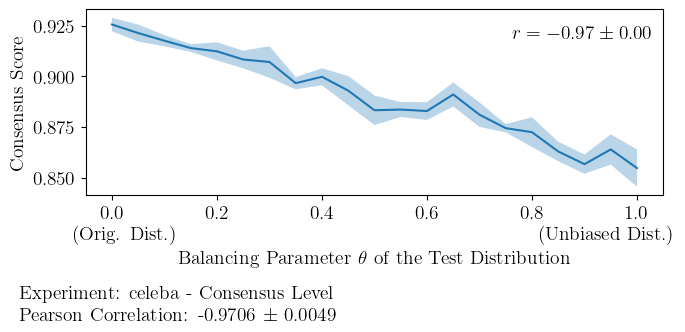

In [25]:
# Measure score function values for each base model.
score_function = consensus_level
score_values = [] # Later shape: [n_base_models, n_balancing_factors]
for base_model_id, base_model in enumerate(base_models):
    # Get predicted probabilities for the test set.
    outputs_test = tasks[base_model]["outputs_test"] # Shape: [n_balancing_factors, n_samples, n_classes].

    # Calculate score function.
    scores_test = np.array([score_function(outputs_test[:,indices,:], base_model_id=base_model_id, indices=indices, subset_name="test") for indices in subset_indices_per_balancing_factor_test])

    score_values.append(scores_test)
score_values = np.array(score_values)

# Calculate Pearson correlation coefficients.
correlation_coefs = [np.corrcoef(balancing_factors, vals)[1,0] for vals in score_values]

# Plot.
mean = np.mean(score_values, axis=0)
std = np.std(score_values, axis=0)

plt.figure(figsize=(7.0,3.0))
plt.plot(balancing_factors, mean, color="C0")
plt.fill_between(balancing_factors, mean+std, mean-std, facecolor="C0", alpha=0.3)
plt.xlabel(r"Balancing Parameter $\theta$ of the Test Distribution", labelpad=20) # Because we add the second row of the xticks manually
plt.ylabel("Consensus Score")

plt.figtext(
    x=0.733,
    y=0.84,
    s=(f"$r={np.mean(correlation_coefs): .2f}\\pm{np.std(correlation_coefs): .2f}$"),
    horizontalalignment='left',
)

plt.figtext(
    x=0.03,
    y=-0.1,
    s=("Experiment: " + dataset_name + f" - Consensus Level\nPearson Correlation: {np.mean(correlation_coefs): .4f} " + r"$\pm$" + f" {np.std(correlation_coefs): .4f}"),
    horizontalalignment='left',
    style="italic"
)

# Add custom tick description.
add_tick_descriptions(
    fig,
    plt.gca(),
    balancing_factors,
    descs=["(Orig. Dist.)", "(Unbiased Dist.)"],
    vertical_offset_factor=1.5,
    horizontal_offset=28,
)

plt.tight_layout()
plt.savefig(join(output_dir, dataset_name + " - dependency consensus level and balancing factor.pdf"), bbox_inches='tight')

### 3.2. Full Pipeline: Learning the Mapping and Adaptive Inference

This section combines the final two steps of the AMSEL pipeline.

**Step 2: Learning the Mapping $M$**
We use the `subset_train_score_mapping` ($\mathcal{D}_{\mathrm{mapping}}$) to learn the mapping $M: s(\mathcal{X}^n) \to \Theta$. We calculate the consensus score for subsets of $\mathcal{D}_{\mathrm{mapping}}$ with varying balancing parameters and train a linear regression model to predict $\theta$ from the score.

**Step 3: Adaptive Inference**
During the evaluation phase, for each simulated test distribution, we:
1.  Calculate its consensus score.
2.  Use the learned regressor $M$ to estimate the test balancing parameter, $\theta_{\mathrm{test}}$.
3.  Select the candidate model $m_{\theta_{\mathrm{test}}}$ whose training parameter is closest to the estimated $\theta_{\mathrm{test}}$.
4.  Evaluate the performance of the selected model on the given test distribution.

The `amsel` function below encapsulates this entire process.

In [26]:
def amsel(
    tasks=tasks,
    balancing_factors=balancing_factors,
    group_ids_train_score_mapping=group_ids_train_score_mapping,
    group_ids_test=group_ids_test,
    subset_train_score_mapping=subset_train_score_mapping,
    subset_test=subset_test,
    erm_predictions=erm_predictions,
    dfr_predictions=dfr_predictions,
    amsel_mode="default",
    model_selection_strategy="naive_model_selection",
    score_function=consensus_level,
    sample_size=None,
    seed=seed,
):
    base_models = list(tasks.keys())
    results = {base_model: {} for base_model in base_models}

    if amsel_mode == "default": # Interpolated balancing + retraining of all classifier heads
        model_prefix = ""
    else:
        raise ValueError("Invalid mode for AMSEL specified. Please select one of 'default'. Given mode was: " + str(amsel_mode))
    
    for base_model_id, base_model in enumerate(base_models):
        # Extract model outputs.
        outputs_train_score_mapping, outputs_test, y_train_score_mapping, y_test = [
            tasks[base_model][z]
            for z in [
                "outputs_" + model_prefix + "train_score_mapping",
                "outputs_" + model_prefix + "test",
                "y_train_score_mapping",
                "y_test",
            ]
        ]

        # Training Phase.
        # 1) Generate subsets with different balancing factors.
        # 2) Identify which classifier performs best for each balancing factor. For
        #    this, we consider overall accuracy.
        # 3) Learn mapping from the score function to balancing factor
        #    \alpha of the dataset.

        # 1. Generate subsets.
        # Generate dataset subsamples with the desired balancing factors.
        # Note that since we set the seed, all models are evaluated on the 
        # same subsets (per balancing factor).
        subset_indices_per_balancing_factor_train_score_mapping = [
            list(
                BalancedSampler(
                    subset_train_score_mapping,
                    mode="exact_under",
                    balancing_factor=balancing_factor,
                    labels=torch.tensor(group_ids_train_score_mapping),
                    seed=seed
                )
            )
            for balancing_factor in balancing_factors
        ]

        # 2. Identify optimal model per balancing factor.
        # Generate predictions for the training split (subset_train_score_mapping).
        assert len(outputs_train_score_mapping.shape) == 3, "Expected shape of predicted probabilities is [n_balancing_factors, n_samples, n_classes]!"
        predictions_train_score_mapping = np.argmax(outputs_train_score_mapping, axis=2) # Shape: [n_balancing_factors, n_samples, n_classes] -> [n_balancing_factors, n_samples].
        predictions_train_score_mapping = predictions_train_score_mapping.transpose() # Shape: [n_balancing_factors, n_samples] -> [n_samples, n_balancing_factors].

        # For each balancing factor, get the best-performing model.
        optimal_dfr_model_indices = np.array([np.argmax([accuracy_score(y_train_score_mapping[indices], p[indices]) for p in predictions_train_score_mapping.T]) for indices in subset_indices_per_balancing_factor_train_score_mapping])

        # 3. Learn mapping for balancing factor.
        # Note that technically speaking, we don't predict the balancing factor but
        # rather the index of the balancing factor, assuming ascending and
        # equidistant balancing factors.
        # Here, we first have to measure the consensus level (or whatever metric
        # we are currently considering) and then train a linear regression to
        # map consensus level -> balancing parameter.
        scores_train_score_mapping = np.array([score_function(outputs_train_score_mapping[:,indices,:], base_model_id=base_model_id, indices=indices, subset_name="train_score_mapping") for indices in subset_indices_per_balancing_factor_train_score_mapping])
        x = scores_train_score_mapping.reshape(-1, 1)
        y = balancing_factors # np.arange(len(scores_train_score_mapping))
        # y = y / np.max(y) # Map to [0,1] -> Just predict actual balancing parameter.
        if score_mapping == "linear_regression":
            reg = LinearRegression()
        else:
            raise ValueError("Invalid estimator for score mapping specified!")
        reg.fit(x, y)

        # Evaluation Phase.
        # 1) Generate subsets with desired balancing factors to evaluate.
        # 2) Measure consensus level.
        # 3) Estimate the balancing factor of the given dataset based on the
        #    consensus level.
        # 4) Choose the appropriate model based on the identified balancing factor
        #    and evaluate with that model.
        # 5) Compare to default ERM and DFR models.

        # 1. Generate subsets.
        # Generate dataset subsamples with the desired balancing factors.
        # Note that since we set the seed, all models are evaluated on the 
        # same subsets (per balancing factor).
        subset_indices_per_balancing_factor_test = [
            list(
                BalancedSampler(
                    subset_test,
                    mode="exact_under",
                    balancing_factor=balancing_factor,
                    labels=torch.tensor(group_ids_test),
                    seed=seed
                )
            )
            for balancing_factor in balancing_factors
        ]

        # Generate predictions for the test split (subset_test).
        assert len(outputs_test.shape) == 3, "Expected shape of predicted probabilities is [n_balancing_factors, n_samples, n_classes]!"
        predictions_test = np.argmax(outputs_test, axis=2) # Shape: [n_balancing_factors, n_samples, n_classes] -> [n_balancing_factors, n_samples].
        predictions_test = predictions_test.transpose() # Shape: [n_balancing_factors, n_samples] -> [n_samples, n_balancing_factors].

        # 2. Measure score function.
        # Here, we estimate the scores on the whole test dataset. To simulate an
        # online-setting, one could also estimate the consensus level only on a
        # subset of all test samples (and use the selected model to predict for
        # all test samples).
        if sample_size is None:
            scores_test = np.array([score_function(outputs_test[:,indices,:], base_model_id=base_model_id, indices=indices, subset_name="test") for indices in subset_indices_per_balancing_factor_test])
        else:
            # Note that we have to use the same indices for slicing outputs_test
            # that we also pass to 'indices'. Thus, we have to re-create the
            # random generator with the same seed.
            scores_test = np.array([score_function(
                outputs_test[:, np.random.default_rng(seed).choice(indices, [sample_size], replace=False), :], # Only consider subset with sample_size samples.
                base_model_id=base_model_id,
                indices=np.random.default_rng(seed).choice(indices, [sample_size], replace=False),
                subset_name="test"
            ) for indices in subset_indices_per_balancing_factor_test])
            
        # 3. Estimate balancing factor.
        # Similarly to above, we technically don't estimate the balancing factor
        # itself but rather its index in balancing_factors.
        # Note that we have to to ensure that all indices are within bounds
        # (linear regression might predict something else). For simplicity, we
        # simply clip the values to the desired interval instead of ensuring
        # this property in the classification procedure.
        x_test = scores_test.reshape(-1, 1)
        # Note:
        # The indices of the balancing factor are enumerated starting from zero:
        # [0, ..., n-1]. Thus, for scaling we have to scale with *(n-1) instead
        # of *n. 
        balancing_factor = reg.predict(x_test)
        balancing_factor_idx = np.round(balancing_factor_to_index(balancing_factor, clip=True)).astype(int)
        # balancing_factor_idx = np.round(reg.predict(x_test) / np.max(balancing_factors) * (len(scores_train_score_mapping) - 1)).astype(int)
        # balancing_factor_idx = np.clip(balancing_factor_idx, a_min=0, a_max=len(balancing_factors) - 1)

        # 4. Select the optimal model and evaluate.
        # Depending on the model selection strategy, we either select the model
        # trained on the simulated distribution with the same balancing factor
        # or the model that performed best on the simulated distribution with
        # this balancing factor.
        if model_selection_strategy == "optimal_model_selection":
            dfr_model_indices = optimal_dfr_model_indices[balancing_factor_idx]
        elif model_selection_strategy == "naive_model_selection":
            dfr_model_indices = balancing_factor_idx
        else:
            raise ValueError("Invalid model selection strategy specified: " + str(model_selection_strategy))
        results[base_model]["amsel_" + amsel_mode + "_"  + model_selection_strategy] = np.array([accuracy_score(y_true=y_test[indices], y_pred=predictions_test[indices][:,dfr_model_idx]) for indices, dfr_model_idx in zip(subset_indices_per_balancing_factor_test, dfr_model_indices)])
        results[base_model]["amsel_" + amsel_mode + "_"  + model_selection_strategy + "_balanced"] = np.array([balanced_accuracy_score(y_true=y_test[indices], y_pred=predictions_test[indices][:,dfr_model_idx]) for indices, dfr_model_idx in zip(subset_indices_per_balancing_factor_test, dfr_model_indices)])
        results[base_model]["amsel_" + amsel_mode + "_"  + model_selection_strategy + "_wsg"] = np.array([worst_subgroup_accuracy(y_true=y_test[indices], y_pred=predictions_test[indices][:,dfr_model_idx], group_ids=group_ids_test[indices]) for indices, dfr_model_idx in zip(subset_indices_per_balancing_factor_test, dfr_model_indices)])
        

        # 5. Evaluate ERM and DFR model on the same subsplits.
        results[base_model]["erm_model"] = np.array([accuracy_score(y_true=y_test[indices], y_pred=erm_predictions[base_model_id,indices]) for indices in subset_indices_per_balancing_factor_test])
        results[base_model]["dfr_model"] = np.array([accuracy_score(y_true=y_test[indices], y_pred=dfr_predictions[base_model_id,indices,unbiased_model_idx]) for indices in subset_indices_per_balancing_factor_test])
        results[base_model]["erm_model_balanced"] = np.array([balanced_accuracy_score(y_true=y_test[indices], y_pred=erm_predictions[base_model_id,indices]) for indices in subset_indices_per_balancing_factor_test])
        results[base_model]["dfr_model_balanced"] = np.array([balanced_accuracy_score(y_true=y_test[indices], y_pred=dfr_predictions[base_model_id,indices,unbiased_model_idx]) for indices in subset_indices_per_balancing_factor_test])
        results[base_model]["erm_model_wsg"] = np.array([worst_subgroup_accuracy(y_true=y_test[indices], y_pred=erm_predictions[base_model_id,indices], group_ids=group_ids_test[indices]) for indices in subset_indices_per_balancing_factor_test])
        results[base_model]["dfr_model_wsg"] = np.array([worst_subgroup_accuracy(y_true=y_test[indices], y_pred=dfr_predictions[base_model_id,indices,unbiased_model_idx], group_ids=group_ids_test[indices]) for indices in subset_indices_per_balancing_factor_test])
    return results

In [27]:
model_selection_strategy = "naive_model_selection" # One of "naive_model_selection", "optimal_model_selection".
score_function = score_functions[score_function_name]

In [28]:
results = {base_model: {} for base_model in base_models}
for amsel_mode in ["default"]:
    r = amsel(
        amsel_mode=amsel_mode,
        model_selection_strategy=model_selection_strategy,
        score_function=score_function,
        sample_size=None,
    )
    results = {k: results[k] | r[k] for k in results.keys()} # Merge results.

## 4. Results and Analysis

In this final section, we evaluate AMSEL and compare its performance against several baselines:
-   **ERM**: The standard model trained with Empirical Risk Minimization.
-   **DFR**: Deep Feature Reweighting, which is equivalent to our candidate model $m_1$ (i.e., $\theta=1$), a fixed debiasing strategy.
-   **EvA**: Erasing with Activations, another post-hoc debiasing method.

### 4.1. Baseline: Erasing with Activations (EvA)

We first implement and evaluate the EvA baseline. EvA identifies and removes spurious feature dimensions by comparing feature distributions from biased and unbiased data.

We train the EvA classifiers on `subset_train_dfr` and select the best-performing classifier (i.e., hyperparameter optimization for the number of neurons to deactivate per class) on `subset_train_bootstrapping`. Then, we evaluate on `subset_test`.

In [29]:
debug_visualization = False
eva_predictions = []
for base_model_id, base_model in enumerate(base_models):
    # 1. Preparation.
    # Outputs and labels.
    X_train_dfr, X_train_score_mapping, X_test, y_train_dfr, y_train_score_mapping, y_test = [
            tasks[base_model][z]
            for z in [
                "X_train_dfr", # Shape: [n_samples, n_features].
                "X_train_score_mapping", # Shape: [n_samples, n_features].
                "X_test", # Shape: [n_samples, n_features].
                "y_train_dfr",
                "y_train_score_mapping",
                "y_test",
            ]
        ]
    indices_balanced_train_dfr = subset_indices_per_balancing_factor_train_dfr[unbiased_model_idx]
    indices_balanced_train_score_mapping = subset_indices_per_balancing_factor_train_score_mapping[unbiased_model_idx]

    # Datasets.
    # For EvA, we need a biased and an unbiased dataset. We consider
    # subset_train_dfr to be our biased dataset and create a balanced version of
    # subset_train_bootstrapping as our unbiased dataset.
    X_biased = X_train_dfr
    y_biased = y_train_dfr
    group_ids_biased = group_ids_train_dfr
    X_unbiased = X_train_score_mapping[indices_balanced_train_score_mapping]
    y_unbiased = y_train_score_mapping[indices_balanced_train_score_mapping]
    group_ids_unbiased = group_ids_train_score_mapping[indices_balanced_train_score_mapping]

    # 2. Identify Spurious Features.
    # Since we have access to an unbalanced variant of the dataset, we can
    # identify the spurious feature dimensions via the consistency measure
    # proposed by He et al. Note that the consistency is measured per feature
    # dimension i and per class K.
    #   c_ik = -d(\phi^(i,k)_{train}, \phi^(i,k)_{unbiased})
    n_classes = len(subset_train_dfr.class_labels)
    n_features = X_biased.shape[1]
    consistency = np.array([[- wasserstein_distance(X_biased[(y_biased == k)][:,i], X_unbiased[y_unbiased == k][:,i]) for k in range(n_classes)] for i in range(n_features)]) # Shape: n_features, n_classes.

    # Visualization.
    if debug_visualization:
        counts, bins = np.histogram(np.mean(consistency, axis=1))
        plt.hist(bins[:-1], bins, weights=counts)
        plt.title("Consistency (Averaged Over Classes, Histogram)")
        plt.show()

    # 3. Train updated classifiers.
    # We train multiple classifiers where we eliminate more and more potentially
    # spurious features. Afterwards, we select the best of those classifiers.
    classifiers, masks = [], []
    n_elimination_candidates = np.linspace(1, n_features, num=100, endpoint=False, dtype=int)
    for n_eliminate_per_class in tqdm(n_elimination_candidates, desc=f"EvA: Training classifier heads with eliminated spurious features (for base model: {base_model})"): # range(1, int(0.5*n_features))):
        # Eliminate top n_eliminate_per_class features per class.
        # From each class, we eliminate the feature dimensions with the lowest
        # consistency. If multiple classes vote for the same feature dimension
        # to be removed, fewer feature dimensions are removed in total.
        assert n_eliminate_per_class < n_features, "At least one feature has to remain after erasing spurious features!"
        assert n_eliminate_per_class > 0, "Remove at least one feature dimension (otherwise, all would be removed)"

        indices_to_eliminate = np.argsort(consistency, axis=0)[:n_eliminate_per_class, :] # Argsort shape: [n_feature_dims, n_classes].
        indices_to_eliminate = np.unique(indices_to_eliminate) # Remove duplicates and flatten.

        # indices_to_eliminate = np.unique([np.where(c <= -0.1) for c in consistency.T])

        # If we would have to remove all features, this would not really make
        # sense. We can apply "break" because all subsequent
        # runs will fail as well.
        if len(indices_to_eliminate) >= n_features:
            break

        mask=np.full(n_features, True, dtype=bool)
        mask[indices_to_eliminate] = False

        # Update input data accordingly.
        X_biased_eliminated = X_biased[:,mask]
        X_unbiased_eliminated = X_unbiased[:,mask]

        # Train updated classifier.
        # Note that this is essentially a logistic regression. By default, l2
        # regularization (weight decay) is applied.
        clf = SGDClassifier(
            loss="log_loss",
            learning_rate="constant", # Scheduler.
            eta0=0.001, # Learning rate.
            class_weight="balanced",
            shuffle=True, # Shuffle data after every epoch.
            n_jobs = -1,
            random_state=seed,
        ).fit(X_biased_eliminated, y_biased)

        # print(y_biased.shape)
        # print("Accuracy on training data:", str(accuracy_score(y_biased, clf.predict(X_biased_eliminated))))
        classifiers.append(clf)
        masks.append(mask)
    
    # 4. Select best-performing classifier on the unbiased dataset.
    # Maybe also select following worst-group accuracy since we have access to groups?
    accuracies = np.array([accuracy_score(y_true=y_unbiased, y_pred=clf.predict(X_unbiased[:,mask])) for clf, mask in zip(classifiers, masks)])
    best_classifier = classifiers[np.argmax(accuracies)]
    best_classifier_mask = masks[np.argmax(accuracies)]

    # Visualization.
    if debug_visualization:
        plt.plot(n_elimination_candidates[:len(accuracies)], accuracies) # Adjust x for skipped runs where all features would have been removed.
        plt.xlabel("Number of Eliminated Feature Dimensions per Class")
        plt.ylabel("Worst-Subgroup Accuracy")
        plt.title("Classifier Selection")
        plt.show()

    # 5. Evaluate.
    predictions_test = best_classifier.predict(X_test[:, best_classifier_mask])
    eva_predictions.append(predictions_test)
    
    results[base_model]["eva_model"] = np.array([accuracy_score(y_true=y_test[indices], y_pred=predictions_test[indices]) for indices in subset_indices_per_balancing_factor_test])
    results[base_model]["eva_model_balanced"] = np.array([balanced_accuracy_score(y_true=y_test[indices], y_pred=predictions_test[indices]) for indices in subset_indices_per_balancing_factor_test])
    results[base_model]["eva_model_wsg"] = np.array([worst_subgroup_accuracy(y_true=y_test[indices], y_pred=predictions_test[indices], group_ids=group_ids_test[indices]) for indices in subset_indices_per_balancing_factor_test])
eva_predictions = np.array(eva_predictions)

print("Training was performed with a biased dataset with " + str(len(X_biased)) + " samples and an unbiased dataset with " + str(len(X_unbiased)) + " samples each.")

EvA: Training classifier heads with eliminated spurious features (for base model: izmailov_resnet50_erm_seed1): 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]
EvA: Training classifier heads with eliminated spurious features (for base model: izmailov_resnet50_erm_seed2): 100%|██████████| 100/100 [00:43<00:00,  2.32it/s]
EvA: Training classifier heads with eliminated spurious features (for base model: izmailov_resnet50_erm_seed3): 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]
EvA: Training classifier heads with eliminated spurious features (for base model: izmailov_resnet50_erm_seed4): 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
EvA: Training classifier heads with eliminated spurious features (for base model: izmailov_resnet50_erm_seed5): 100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


Training was performed with a biased dataset with 9933 samples and an unbiased dataset with 328 samples each.


### 4.2. Performance on Varying Test Distributions

The following plots show the core results of our experiments. We plot the performance (Accuracy, Balanced Accuracy, and Worst-Group Accuracy) of AMSEL and the baseline methods across the full range of simulated test distributions, from highly biased ($\theta=0$) to fully unbiased ($\theta=1$).

The results demonstrate that while fixed methods like ERM and DFR excel at opposite ends of the spectrum, AMSEL successfully adapts, maintaining high performance across all levels of spurious correlation.

In [30]:
suffixes = {
    "Accuracy": "",
    "Balanced Accuracy": "_balanced",
    "Worst-Group Accuracy": "_wsg",
}
metrics = list(suffixes.keys())

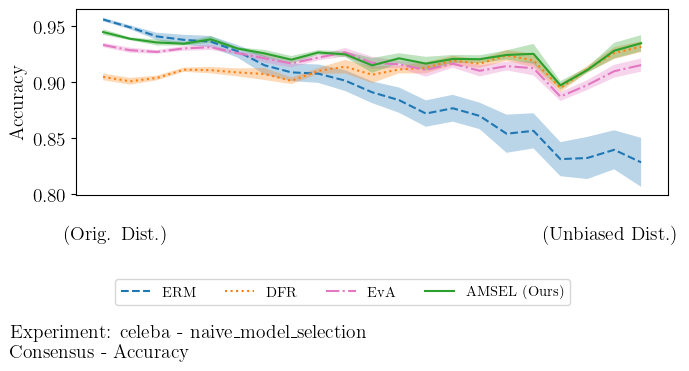

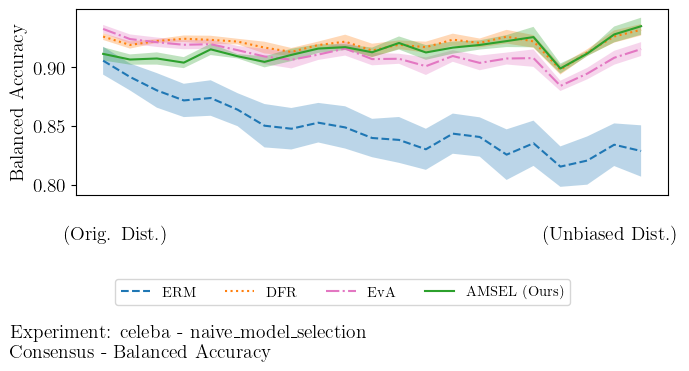

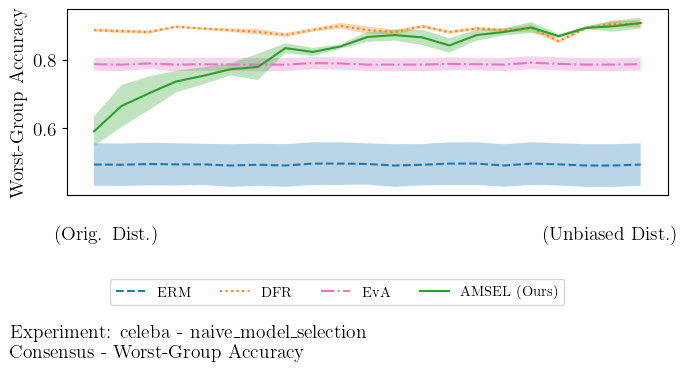

In [31]:
for metric in metrics:
    suffix = suffixes[metric]

    # ==========================================================================
    # 1. Load evaluation results.
    # ==========================================================================

    # Extract results without aggregation.
    # Shape of the results is [n_base_models, n_balancing_parameters (test
    # distributions)].
    erm_performance = np.array([results[base_model]["erm_model" + suffix] for base_model in base_models])
    dfr_performance = np.array([results[base_model]["dfr_model" + suffix] for base_model in base_models])
    eva_performance = np.array([results[base_model]["eva_model" + suffix] for base_model in base_models])
    amsel_performance = np.array([results[base_model]["amsel_default_" + model_selection_strategy + suffix] for base_model in base_models])

    # ==========================================================================
    # 2. Plot with standard deviations.
    # ==========================================================================

    plt.figure(figsize=(7.0, 3.0))

    # ERM Model.
    mean, std = np.mean(erm_performance, axis=0), np.std(erm_performance, axis=0)
    plt.plot(
        balancing_factors,
        mean,
        label="ERM Model",
        color=colors["ERM"][0],
        linestyle=colors["ERM"][2],
    )
    plt.fill_between(
        balancing_factors,
        mean+std,
        mean-std,
        facecolor=colors["ERM"][0],
        alpha=0.3
    )

    # DFR Model.
    mean, std = np.mean(dfr_performance, axis=0), np.std(dfr_performance, axis=0)
    plt.plot(
        balancing_factors,
        mean,
        label="DFR Model",
        color=colors["DFR"][0],
        linestyle=colors["DFR"][2],
    )
    plt.fill_between(
        balancing_factors,
        mean+std,
        mean-std,
        facecolor=colors["DFR"][0],
        alpha=0.3
    )

    # EvA (Eliminating Spurious Correlations with Activations).
    mean, std = np.mean(eva_performance, axis=0), np.std(eva_performance, axis=0)
    plt.plot(
        balancing_factors,
        mean,
        label="EvA Model",
        color=colors["EvA"][0],
        linestyle=colors["EvA"][2],
    )
    plt.fill_between(
        balancing_factors,
        mean+std,
        mean-std,
        facecolor=colors["EvA"][0],
        alpha=0.3
    )
    
    # AMSEL (Ours).
    mean, std = np.mean(amsel_performance, axis=0), np.std(amsel_performance, axis=0)
    plt.plot(
        balancing_factors,
        mean,
        label="AMSEL (Ours)",
        color=colors["AMSEL (Ours)"][0],
        linestyle=colors["AMSEL (Ours)"][2],
    )
    plt.fill_between(
        balancing_factors,
        mean+std,
        mean-std,
        facecolor=colors["AMSEL (Ours)"][0],
        alpha=0.3
    )

    # Axis labels.
    plt.xlabel(r"Balancing Parameter $\theta$ of the Test Distribution", labelpad=20) # Because we add the second row of the xticks manually
    plt.ylabel(metric)
    plt.tight_layout()
    
    # Add custom tick description.
    add_tick_descriptions(
        fig,
        plt.gca(),
        balancing_factors,
        descs=["(Orig. Dist.)", "(Unbiased Dist.)"],
        vertical_offset_factor=1.5,
        horizontal_offset=28,
    )

    # Small adjustments for paper displayment.
    # For CelebA, make x-ticks and x-label invisible because the accuracy
    # plots are above the worst-group accuracy plots and these two share the
    # x-axis labeling.
    # Note that we cannot disable them because that would change the spacing
    # (especially since the x-ticks extend the margin to the right).
    if dataset_name == "celeba":
        plt.gca().xaxis.label.set_color("white")
        plt.gca().tick_params(axis='x', colors="white")

    # Custom legend.
    # Make sure that this is called after tight_layout().
    handles = [Line2D([0], [0], label=name, color=color[0], linestyle=color[2]) for name, color in colors.items() if not name == "Approximated AMSEL (Ours)"]
    plt.legend(
        handles=handles,
        loc='lower center',
        bbox_to_anchor=(0.45, -0.63), # bbox_to_anchor=(1, 0.5),
        prop={'size': 10.5},
        ncol=len(handles)
    )

    plt.figtext(
        x=0.03,
        y=-0.23,
        s=("Experiment: " + dataset_name + " - " + model_selection_strategy + "\n" + score_function_name + " - " + metric),
        horizontalalignment='left',
        style="italic"
    )

    plt.savefig(join(output_dir, dataset_name + " - " + model_selection_strategy + " - " + score_function_name + " - " + metric + " - " + " - lineplot.pdf"), bbox_inches='tight')
    plt.show()

In [32]:
for metric in metrics:
    suffix = suffixes[metric]

    # ==========================================================================
    # 1. Load evaluation results.
    # ==========================================================================

    # Extract means and standard deviations.
    erm_performance = np.mean([results[base_model]["erm_model" + suffix] for base_model in base_models], axis=0)
    dfr_performance = np.mean([results[base_model]["dfr_model" + suffix] for base_model in base_models], axis=0)
    eva_performance = np.mean([results[base_model]["eva_model" + suffix] for base_model in base_models], axis=0)
    amsel_performance = np.mean([results[base_model]["amsel_default_" + model_selection_strategy + suffix] for base_model in base_models], axis=0)

    erm_performance_std = np.std([results[base_model]["erm_model" + suffix ] for base_model in base_models], axis=0)
    dfr_performance_std = np.std([results[base_model]["dfr_model" + suffix] for base_model in base_models], axis=0)
    eva_performance_std = np.std([results[base_model]["eva_model" + suffix] for base_model in base_models], axis=0)
    amsel_performance_std = np.std([results[base_model]["amsel_default_" + model_selection_strategy + suffix] for base_model in base_models], axis=0)


    # ==========================================================================
    # 2. Export to LaTeX.
    # ==========================================================================

    # Output LaTeX.
    n_skip = 1
    index = balancing_factors[::n_skip].tolist()

    df = pd.DataFrame(
        {
            "Balancing Factor": index,
            "ERM Model": erm_performance[::n_skip],
            "DFR Model": dfr_performance[::n_skip],
            "EvA Model": eva_performance[::n_skip],
            "AMSEL (Ours)": amsel_performance[::n_skip],
            "ERM Model (Std)": erm_performance_std[::n_skip],
            "DFR Model (Std)": dfr_performance_std[::n_skip],
            "EvA Model (Std)": eva_performance_std[::n_skip],
            "AMSEL (Ours) (Std)": amsel_performance_std[::n_skip],
        }
    )
    display_df(df)

    # Find max values per row.
    # Here, we only consider the first 4 digits (i.e., percentages + 2 decimal
    # points).
    performance_cols = ["ERM Model", "DFR Model", "EvA Model", "AMSEL (Ours)"]
    df["Max Value"] = df[performance_cols].round(4).max(axis=1)

    # Format table with bold max values per row
    def format_value(row, col):
        value = row[col]
        formatted_value = f"{value:>6.2%}".replace(" ", "\\phantom{0}")

        std_col = col + " (Std)"
        std_value = f"{row[std_col]:>6.2%}".replace(" ", "\\phantom{0}")
        
        formatted_value = f"{formatted_value} ± {std_value}"

        # Bold if it's the max in the row
        if value.round(4) == row["Max Value"]:
            formatted_value = f"\\textbf{{{formatted_value}}}"
        
        return formatted_value

    df_formatted = pd.DataFrame(
        {
            r"Balancing Parameter $\theta$": df["Balancing Factor"].apply(lambda x: f"{x:.2f}"),
            "ERM Model": df.apply(lambda row: format_value(row, "ERM Model"), axis=1),
            "DFR Model": df.apply(lambda row: format_value(row, "DFR Model"), axis=1),
            "EvA Model": df.apply(lambda row: format_value(row, "EvA Model"), axis=1),
            "AMSEL (Ours)": df.apply(lambda row: format_value(row, "AMSEL (Ours)"), axis=1),
        }
    )

    # Remove helper column
    df_formatted.drop(columns=["Max Value"], errors="ignore", inplace=True)

    # Convert to LaTeX
    print("Evaluation results for metric: " + metric)
    print(df_formatted.to_latex(index=False).replace("%", "\\%"))

    # Export.
    with open(join(".", "outputs", dataset_name, dataset_name + " - " + model_selection_strategy + " - " + score_function_name + " - " + metric + " on test subset.tex"), "w") as f:
        f.write(df_formatted.to_latex(index=False).replace("%", "\\%"))

,Balancing Factor,ERM Model,DFR Model,EvA Model,AMSEL (Ours),ERM Model (Std),DFR Model (Std),EvA Model (Std),AMSEL (Ours) (Std)
0,0.000000,0.955926,0.904759,0.933203,0.944715,0.001587,0.002985,0.001978,0.002507
1,0.050000,0.948935,0.900843,0.928518,0.938726,0.001734,0.003023,0.002265,0.001317
2,0.100000,0.940806,0.903810,0.927002,0.935432,0.003248,0.002081,0.001665,0.002668
3,0.150000,0.937786,0.911172,0.930153,0.934321,0.004498,0.001875,0.002115,0.001670
4,0.200000,0.936176,0.910786,0.931212,0.938212,0.005049,0.002864,0.002484,0.002891
5,0.250000,0.927553,0.908748,0.925934,0.930019,0.005643,0.003560,0.001252,0.001079
6,0.300000,0.915113,0.907330,0.921357,0.925701,0.008243,0.005319,0.003812,0.003101
7,0.350000,0.908779,0.901299,0.916779,0.920104,0.007821,0.002957,0.003560,0.003276
8,0.400000,0.907629,0.910094,0.921948,0.926526,0.008187,0.002609,0.002545,0.002080
9,0.450000,0.901438,0.913856,0.926667,0.924837,0.009284,0.006095,0.003842,0.002581


Evaluation results for metric: Accuracy
\begin{tabular}{lllll}
\toprule
Balancing Parameter \$\textbackslash theta\$ &                          ERM Model &                          DFR Model &                          EvA Model &                       AMSEL (Ours) \\
\midrule
                        0.00 & \textbackslash textbf\{95.59\\% ± \textbackslash phantom\{0\}0.16\\%\} &          90.48\\% ± \textbackslash phantom\{0\}0.30\\% &          93.32\\% ± \textbackslash phantom\{0\}0.20\\% &          94.47\\% ± \textbackslash phantom\{0\}0.25\\% \\
                        0.05 & \textbackslash textbf\{94.89\\% ± \textbackslash phantom\{0\}0.17\\%\} &          90.08\\% ± \textbackslash phantom\{0\}0.30\\% &          92.85\\% ± \textbackslash phantom\{0\}0.23\\% &          93.87\\% ± \textbackslash phantom\{0\}0.13\\% \\
                        0.10 & \textbackslash textbf\{94.08\\% ± \textbackslash phantom\{0\}0.32\\%\} &          90.38\\% ± \textbackslash phantom\{0\}0.21\\% &          9

/tmp/ipykernel_829287/1542672715.py:80: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_formatted.to_latex(index=False).replace("%", "\\%"))
/tmp/ipykernel_829287/1542672715.py:84: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df_formatted.to_latex(index=False).replace("%", "\\%"))


,Balancing Factor,ERM Model,DFR Model,EvA Model,AMSEL (Ours),ERM Model (Std),DFR Model (Std),EvA Model (Std),AMSEL (Ours) (Std)
0,0.000000,0.905443,0.925906,0.932389,0.911192,0.011872,0.002854,0.003449,0.005632
1,0.050000,0.891571,0.918780,0.923788,0.906378,0.011464,0.003090,0.003954,0.004371
2,0.100000,0.880133,0.922142,0.921093,0.907271,0.014692,0.001601,0.004004,0.005197
3,0.150000,0.871614,0.924064,0.918927,0.903746,0.014158,0.002786,0.003806,0.004676
4,0.200000,0.873662,0.923130,0.919431,0.915043,0.015097,0.003496,0.003923,0.004830
5,0.250000,0.863739,0.921661,0.914349,0.909186,0.014026,0.002382,0.003599,0.001864
6,0.300000,0.850109,0.916538,0.908985,0.904394,0.018441,0.005011,0.006547,0.004681
7,0.350000,0.847547,0.912892,0.906154,0.910331,0.017643,0.003314,0.007319,0.005243
8,0.400000,0.852675,0.918710,0.910597,0.915702,0.016819,0.002960,0.004562,0.003696
9,0.450000,0.848656,0.921605,0.915714,0.916934,0.017973,0.005924,0.005973,0.002457


Evaluation results for metric: Balanced Accuracy
\begin{tabular}{lllll}
\toprule
Balancing Parameter \$\textbackslash theta\$ &                 ERM Model &                          DFR Model &                          EvA Model &                       AMSEL (Ours) \\
\midrule
                        0.00 & 90.54\\% ± \textbackslash phantom\{0\}1.19\\% &          92.59\\% ± \textbackslash phantom\{0\}0.29\\% & \textbackslash textbf\{93.24\\% ± \textbackslash phantom\{0\}0.34\\%\} &          91.12\\% ± \textbackslash phantom\{0\}0.56\\% \\
                        0.05 & 89.16\\% ± \textbackslash phantom\{0\}1.15\\% &          91.88\\% ± \textbackslash phantom\{0\}0.31\\% & \textbackslash textbf\{92.38\\% ± \textbackslash phantom\{0\}0.40\\%\} &          90.64\\% ± \textbackslash phantom\{0\}0.44\\% \\
                        0.10 & 88.01\\% ± \textbackslash phantom\{0\}1.47\\% & \textbackslash textbf\{92.21\\% ± \textbackslash phantom\{0\}0.16\\%\} &          92.11\\% ± \textbackslash ph

/tmp/ipykernel_829287/1542672715.py:80: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_formatted.to_latex(index=False).replace("%", "\\%"))
/tmp/ipykernel_829287/1542672715.py:84: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df_formatted.to_latex(index=False).replace("%", "\\%"))


,Balancing Factor,ERM Model,DFR Model,EvA Model,AMSEL (Ours),ERM Model (Std),DFR Model (Std),EvA Model (Std),AMSEL (Ours) (Std)
0,0.000000,0.494444,0.885861,0.786667,0.591111,0.061764,0.004554,0.018791,0.043119
1,0.050000,0.493855,0.882786,0.785475,0.664804,0.061767,0.005366,0.018896,0.061300
2,0.100000,0.496089,0.880348,0.788827,0.701676,0.061948,0.004782,0.016345,0.049035
3,0.150000,0.494972,0.895869,0.785475,0.736313,0.061463,0.003068,0.018896,0.031484
4,0.200000,0.494972,0.890442,0.786592,0.753073,0.059920,0.003599,0.018829,0.024834
5,0.250000,0.491620,0.885677,0.785475,0.772067,0.062109,0.005480,0.018896,0.017453
6,0.300000,0.493855,0.881040,0.785475,0.778771,0.061259,0.008732,0.018896,0.038316
7,0.350000,0.491620,0.871959,0.785475,0.833520,0.062109,0.006006,0.018896,0.013866
8,0.400000,0.497207,0.886670,0.789944,0.822346,0.062109,0.005240,0.017877,0.011930
9,0.450000,0.497207,0.898295,0.788827,0.837989,0.062109,0.008438,0.017807,0.006120


Evaluation results for metric: Worst-Group Accuracy
\begin{tabular}{lllll}
\toprule
Balancing Parameter \$\textbackslash theta\$ &                 ERM Model &                          DFR Model &                 EvA Model &                       AMSEL (Ours) \\
\midrule
                        0.00 & 49.44\\% ± \textbackslash phantom\{0\}6.18\\% & \textbackslash textbf\{88.59\\% ± \textbackslash phantom\{0\}0.46\\%\} & 78.67\\% ± \textbackslash phantom\{0\}1.88\\% &          59.11\\% ± \textbackslash phantom\{0\}4.31\\% \\
                        0.05 & 49.39\\% ± \textbackslash phantom\{0\}6.18\\% & \textbackslash textbf\{88.28\\% ± \textbackslash phantom\{0\}0.54\\%\} & 78.55\\% ± \textbackslash phantom\{0\}1.89\\% &          66.48\\% ± \textbackslash phantom\{0\}6.13\\% \\
                        0.10 & 49.61\\% ± \textbackslash phantom\{0\}6.19\\% & \textbackslash textbf\{88.03\\% ± \textbackslash phantom\{0\}0.48\\%\} & 78.88\\% ± \textbackslash phantom\{0\}1.63\\% &          70.1

/tmp/ipykernel_829287/1542672715.py:80: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_formatted.to_latex(index=False).replace("%", "\\%"))
/tmp/ipykernel_829287/1542672715.py:84: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df_formatted.to_latex(index=False).replace("%", "\\%"))


To provide a single-number summary of overall performance, we calculate the Area Under the Curve (AUC) for the accuracy plots. A higher AUC indicates better average performance across the entire spectrum of test distributions.

In [33]:
# We consider accuracy.
suffix = ""

# Extract results without aggregation.
# Shape of the results is [n_base_models, n_balancing_parameters (test
# distributions)].
erm_performance = np.array([results[base_model]["erm_model" + suffix] for base_model in base_models])
dfr_performance = np.array([results[base_model]["dfr_model" + suffix] for base_model in base_models])
eva_performance = np.array([results[base_model]["eva_model" + suffix] for base_model in base_models])
amsel_performance = np.array([results[base_model]["amsel_default_" + model_selection_strategy + suffix] for base_model in base_models])

# Calculate AuCs.
area_under_the_curve = {
    "Model": ["ERM Model", "DFR Model", "EvA Model", "AMSEL (Ours)"],
    "AuC": [],
}
for performance in [erm_performance, dfr_performance, eva_performance, amsel_performance]:
    aucs = [auc(balancing_factors, p) for p in performance]
    area_under_the_curve["AuC"].append(f"${np.mean(aucs):.3f} \\pm {np.std(aucs): .3f}$")

# Highlight maximum element.
max_index = np.argmax(area_under_the_curve["AuC"])
area_under_the_curve["AuC"][max_index] = r"\textbf{" + area_under_the_curve["AuC"][max_index] + "}"

area_under_the_curve = pd.DataFrame(area_under_the_curve)
display_df(area_under_the_curve)
print(area_under_the_curve.to_latex(index=False))

# # Export.
with open(join(output_dir, dataset_name + " - " + model_selection_strategy + " - " + score_function_name + " - AuC Accuracy.tex"), "w") as f:
    f.write(area_under_the_curve.to_latex(index=False))

,Model,AuC
0,ERM Model,$0.891 \pm 0.010$
1,DFR Model,$0.911 \pm 0.003$
2,EvA Model,$0.917 \pm 0.003$
3,AMSEL (Ours),\textbf{$0.925 \pm 0.002$}


\begin{tabular}{ll}
\toprule
       Model &                         AuC \\
\midrule
   ERM Model &          \$0.891 \textbackslash pm  0.010\$ \\
   DFR Model &          \$0.911 \textbackslash pm  0.003\$ \\
   EvA Model &          \$0.917 \textbackslash pm  0.003\$ \\
AMSEL (Ours) & \textbackslash textbf\{\$0.925 \textbackslash pm  0.002\$\} \\
\bottomrule
\end{tabular}



/tmp/ipykernel_829287/4226989613.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(area_under_the_curve.to_latex(index=False))
/tmp/ipykernel_829287/4226989613.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(area_under_the_curve.to_latex(index=False))


### 4.3. Accuracy Trade-off Analysis

This plot visualizes the trade-off between performance on the original biased test distribution ($\theta=0$) and a fully unbiased one ($\theta=1$). Each point on the green line represents one of our candidate models, $m_\theta$. The line traces the Pareto front of models optimized for different bias levels. Fixed methods like ERM and DFR occupy single points in this space. AMSEL's strength lies in its ability to dynamically select an appropriate model from this front based on the test data, thereby navigating the trade-off effectively.

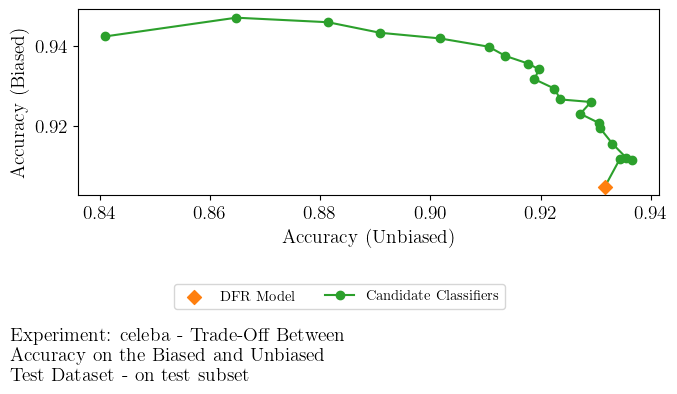

In [34]:
# Setup.
# In order to evaluate the methods on a balanced test distribution, we first
# have to extract the corresponding indices w.r.t. to the original test dataset.
indices_unbiased_testset = subset_indices_per_balancing_factor_test[-1]

plt.figure(figsize=(7.0,2.8))
# plt.figure(figsize=(7.5,3.5))

# ERM model.
# erm_accuracy_unbiased = np.mean([accuracy_score(labels_test[indices_unbiased_testset], p[indices_unbiased_testset]) for p in erm_predictions], axis=0)
# erm_accuracy_biased = np.mean([accuracy_score(labels_test, p) for p in erm_predictions], axis=0)

# plt.scatter(
#     erm_accuracy_unbiased,
#     erm_accuracy_biased,
#     marker="D",
#     s=50,
#     color=colors["ERM"][0],
#     label="ERM Model",
#     zorder=1,
# )

# DFR model.
dfr_accuracy_unbiased = np.mean([accuracy_score(labels_test[indices_unbiased_testset], p[indices_unbiased_testset]) for p in dfr_predictions[:,:,unbiased_model_idx]], axis=0)
dfr_accuracy_biased = np.mean([accuracy_score(labels_test, p) for p in dfr_predictions[:,:,unbiased_model_idx]], axis=0)

plt.scatter(
    dfr_accuracy_unbiased,
    dfr_accuracy_biased,
    marker="D",
    s=50,
    color=colors["DFR"][0],
    label="DFR Model",
    zorder=4,
)

# Retrained candidate classifiers.
candidate_classifiers_accuracy_unbiased = np.mean(
    np.array(
        [
            [accuracy_score(labels_test[indices_unbiased_testset], p[indices_unbiased_testset]) for p in predictions.T]
            for predictions in dfr_predictions
        ]
    ),
    axis=0,
)
candidate_classifiers_accuracy_biased = np.mean(
    np.array(
        [
            [accuracy_score(labels_test, p) for p in predictions.T]
            for predictions in dfr_predictions
        ]
    ),
    axis=0,
)

plt.plot(
    candidate_classifiers_accuracy_unbiased,
    candidate_classifiers_accuracy_biased,
    label="Candidate Classifiers",
    marker="o",
    color=colors["AMSEL (Ours)"][0],
    zorder=3,
)

plt.xlabel("Accuracy (Unbiased)")
plt.ylabel("Accuracy (Biased)")
# plt.title(dataset_name + " - Trade-Off Between Accuracy on the Biased and Unbiased Test Dataset\n- on test subset", pad=20)
plt.tight_layout()

# Legend.
# Make sure that this is called after tight_layout().
plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.45, -0.65), # bbox_to_anchor=(1, 0.5),
    prop={'size': 10.5},
    ncol=len(handles)
)

plt.figtext(
    x=0.03,
    y=-0.4,
    s=("Experiment: " + dataset_name + " - Trade-Off Between\nAccuracy on the Biased and Unbiased\nTest Dataset - on test subset"),
    horizontalalignment='left',
    style="italic"
)

plt.savefig(join(output_dir, dataset_name + " - Trade-Off Between Accuracy on the Biased and Unbiased Test Dataset" " - " + ".pdf"), bbox_inches='tight')